In [43]:
import numba
import sys
sys.path.insert(0, './python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import random
from collections import defaultdict
import torch
import math
import solvers

In [44]:
%matplotlib inline

In [157]:
m = n = l = 4 # L of square grid

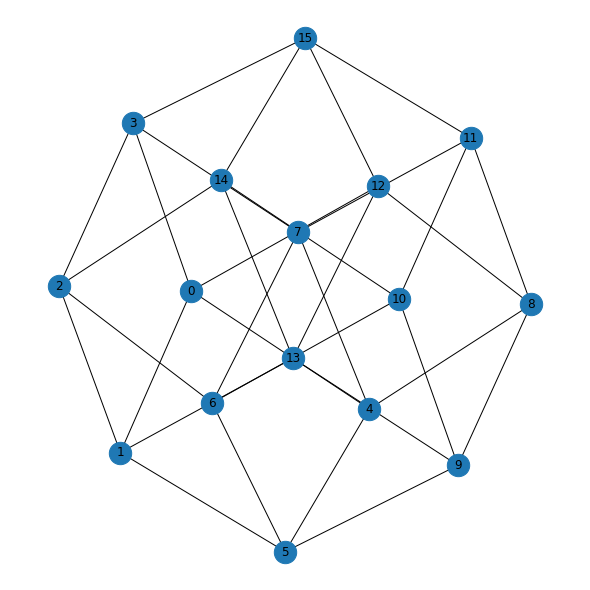

In [177]:
import imp 

import graph_gen
imp.reload(graph_gen)

periodic = True
N, J_interaction = graph_gen.grid_2d_interaction(n,m, periodic=periodic)

#H = np.random.random(N)
H=np.zeros(N)

betas_fast = np.arange(0.1,2.1,1e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
#J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

In [178]:
tree = model.model(N, H, J, J_interaction)

In [179]:
import solvers
imp.reload(solvers)
res_ex = solvers.exact_sol(tree, betas_fast)

beta: 0.1, Fe: -7.033 Energy: -0.206 M: -3.96e-18 S: 0.683022
beta: 0.2, Fe: -3.679 Energy: -0.456 M: 8.78e-19 S: 0.644
beta: 0.3, Fe: -2.664 Energy: -0.844 M: 1.02e-17 S: 0.546
beta: 0.4, Fe: -2.275 Energy: -1.38 M: 0.0 S: 0.35835.658
beta: 0.5, Fe: -2.138 Energy: -1.76 M: 0.0 S: 0.191-33.19
beta: 0.6, Fe: -2.089 Energy: -1.91 M: 0.0 S: 0.109-32.43
beta: 0.7, Fe: -2.068 Energy: -1.96 M: 0.0 S: 0.073132.11
beta: 0.8, Fe: -2.056 Energy: -1.98 M: 0.0 S: 0.057332.10
beta: 0.9, Fe: -2.049 Energy: -1.99 M: 0.0 S: 0.05 -32.00
beta: 1.0, Fe: -2.044 Energy: -2.0 M: 0.0 S: 0.0465-32.00
beta: 1.1, Fe: -2.040 Energy: -2.0 M: -5.36e-14 S: 0.0449
beta: 1.2, Fe: -2.036 Energy: -2.0 M: 0.0 S: 0.0441-32.00
beta: 1.3, Fe: -2.033 Energy: -2.0 M: 0.0 S: 0.0437-32.00
beta: 1.4, Fe: -2.031 Energy: -2.0 M: 0.0 S: 0.0435-32.00
beta: 1.5, Fe: -2.029 Energy: -2.0 M: 0.0 S: 0.0434-32.00
beta: 1.6, Fe: -2.027 Energy: -2.0 M: 0.0 S: 0.0434-32.00
beta: 1.7, Fe: -2.025 Energy: -2.0 M: 0.0 S: 0.0433-32.00
beta: 1.8,

In [180]:
import solvers
imp.reload(solvers)

res_nn = solvers.nn_sol(tree, betas_fast, max_step=1000, bias = True, 
                        z2 = False, x_hat_clip = False)
res_nn["name"]="nn"

fe: -7.032 std_fe: 3.20E-02 M: -0.003 S: 0.683 E: -0.205 0.00125, B1 = -0.0011
fe: -3.672 std_fe: 6.60E-02 M: 0.008 S: 0.649 E: -0.428: 0.00687, B1 = 0.00240
fe: -2.635 std_fe: 1.07E-01 M: 0.005 S: 0.570 E: -0.734: 0.0186, B1 = -0.01212
fe: -2.234 std_fe: 8.60E-02 M: -0.006 S: 0.324 E: -1.425 -0.0317, B1 = 0.00842
fe: -2.121 std_fe: 3.76E-02 M: -0.010 S: 0.148 E: -1.826 0.001, B1 = -0.009104
fe: -2.083 std_fe: 1.68E-02 M: -0.011 S: 0.087 E: -1.939 -0.0421, B1 = 0.00633
fe: -2.066 std_fe: 7.96E-03 M: -0.007 S: 0.063 E: -1.976 0.0526, B1 = 0.004558
fe: -2.056 std_fe: 2.43E-03 M: -0.020 S: 0.052 E: -1.990 -0.022, B1 = 0.002023
fe: -2.049 std_fe: 1.18E-03 M: 0.005 S: 0.047 E: -1.996 0.0276, B1 = -0.000134
fe: -2.044 std_fe: 1.11E-03 M: -0.012 S: 0.046 E: -1.998-0.01, B1 = -0.001225
fe: -2.039 std_fe: 9.40E-04 M: -0.023 S: 0.044 E: -1.999.02, B1 = -0.0030033
fe: -2.036 std_fe: 5.18E-03 M: -0.001 S: 0.045 E: -1.999008, B1 = -0.0053
fe: -2.033 std_fe: 5.27E-03 M: 0.017 S: 0.044 E: -1.999.052,

In [181]:
res_nn_z2 = solvers.nn_sol(tree, betas_fast, max_step=1000,
                           bias = True, z2 = True, x_hat_clip = False)
res_nn_z2["name"]="nn_z2"

fe: -7.033 std_fe: 2.29E-02 M: -0.006 S: 0.683 E: -0.205 0.0015, B1 = -0.13444
fe: -3.676 std_fe: 3.53E-02 M: 0.008 S: 0.644 E: -0.456: -0.0101, B1 = -0.4043
fe: -2.660 std_fe: 4.18E-02 M: 0.002 S: 0.549 E: -0.829: -0.000375, B1 = -0.959
fe: -2.271 std_fe: 3.24E-02 M: 0.002 S: 0.355 E: -1.384: 0.00925, B1 = -1.9617
fe: -2.137 std_fe: 1.55E-02 M: 0.008 S: 0.188 E: -1.760: -0.0386, B1 = -3.2029
fe: -2.089 std_fe: 5.50E-03 M: -0.016 S: 0.108 E: -1.909 0.000625, B1 = -4.335
fe: -2.068 std_fe: 1.88E-03 M: -0.003 S: 0.071 E: -1.967 0.00575, B1 = -5.3081
fe: -2.056 std_fe: 3.27E-04 M: 0.006 S: 0.058 E: -1.984: -0.0256, B1 = -6.2236
fe: -2.049 std_fe: 2.41E-04 M: -0.005 S: 0.050 E: -1.9940.0775, B1 = -7.110003
fe: -2.044 std_fe: 1.43E-03 M: -0.020 S: 0.046 E: -1.998.004, B1 = -7.6506451
fe: -2.039 std_fe: 2.45E-03 M: -0.005 S: 0.046 E: -1.998.0, B1 = -7.7177.712
fe: -2.036 std_fe: 3.77E-03 M: -0.012 S: 0.045 E: -1.998.01, B1 = -7.8104966
fe: -2.033 std_fe: 4.04E-03 M: -0.008 S: 0.045 E: -1.999

In [182]:
import bp_solver
imp.reload(bp_solver)
import solvers
imp.reload(solvers)
res_bp = solvers.bp_sol(tree, betas_fast, val_rand=0.1)
res_bp["name"]="bp"

fe: -7.031, ener: -0.199, M: 0.000, iter 10
fe: -3.664, ener: -0.395, M: 0.000, iter 13
fe: -2.606, ener: -0.583, M: 0.000, iter 47
fe: -2.165, ener: -1.315, M: 0.736, iter 42
fe: -2.050, ener: -1.768, M: 0.929, iter 14
fe: -2.017, ener: -1.912, M: 0.975, iter 9
fe: -2.006, ener: -1.964, M: 0.990, iter 8
fe: -2.002, ener: -1.985, M: 0.996, iter 7
fe: -2.001, ener: -1.994, M: 0.998, iter 6
fe: -2.000, ener: -1.997, M: 0.999, iter 5
fe: -2.000, ener: -1.999, M: 1.000, iter 5
fe: -2.000, ener: -1.999, M: 1.000, iter 5
fe: -2.000, ener: -2.000, M: 1.000, iter 4
fe: -2.000, ener: -2.000, M: 1.000, iter 4
fe: -2.000, ener: -2.000, M: 1.000, iter 4
fe: -2.000, ener: -2.000, M: 1.000, iter 4
fe: -2.000, ener: -2.000, M: 1.000, iter 4
fe: -2.000, ener: -2.000, M: 1.000, iter 3
fe: -2.000, ener: -2.000, M: 1.000, iter 3
fe: -2.000, ener: -2.000, M: 1.000, iter 3


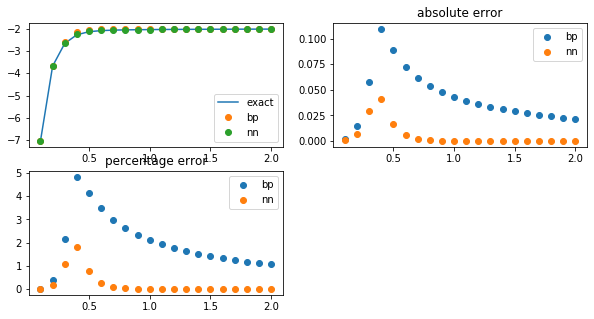

In [183]:
%matplotlib inline
import imp
imp.reload(solvers)
label="fe"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn], init_=0)
#plt.ylim(-0.001,0.11)
plt.show()

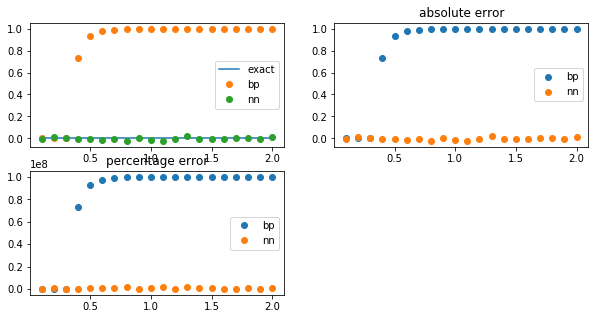

In [184]:
%matplotlib inline
label="M"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn])
plt.show()

./python_lib/solvers.py:277: RuntimeWarning: divide by zero encountered in true_divide
  if j < i and J_interaction[i][j] != 0:


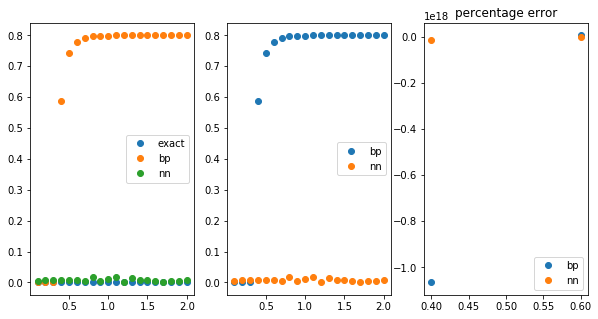

In [185]:
%matplotlib inline
label="M_i"
plt= solvers.plot_quantity_sum(label, res_ex, [res_bp, res_nn], init_=0)
plt.show()

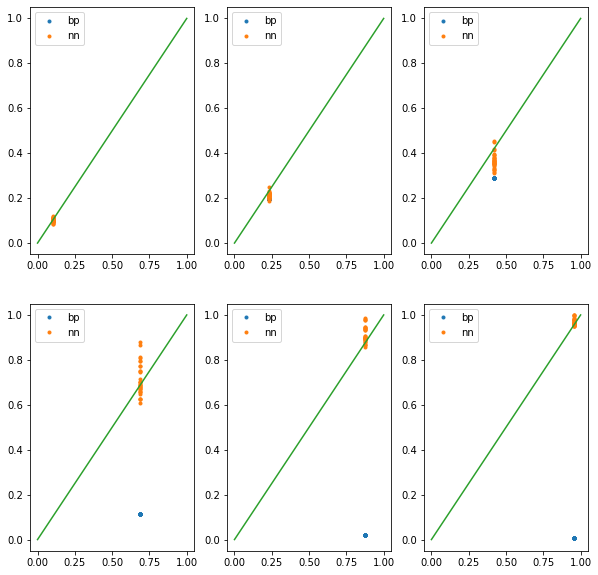

In [186]:
import solvers
imp.reload(solvers)
plt = solvers.plot_all_corr(betas_fast[0:6], res_ex, [res_bp, res_nn], J_interaction)
plt.show()

# With random field

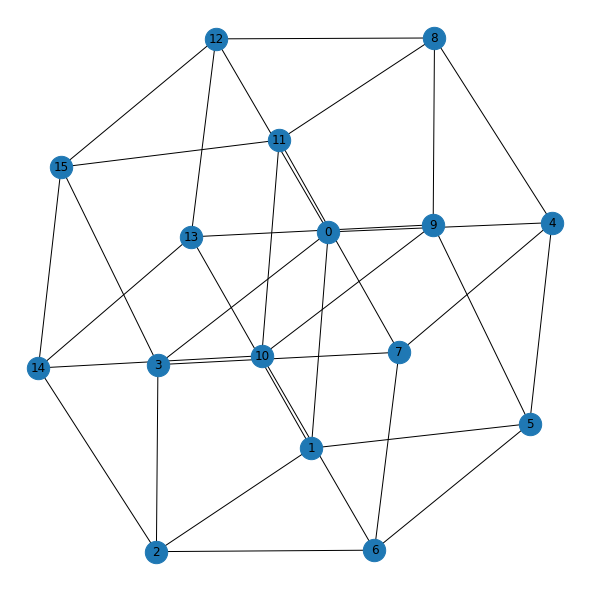

In [200]:
periodic = True
N, J_interaction = graph_gen.grid_2d_interaction(n,m, periodic=periodic)

H_coeff = 6
H = H_coeff * (1. - 2 * np.random.random(N))
#H=np.zeros(N)

betas_fast = np.arange(1e-6,1.5,2e-1)

j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
#J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

In [201]:
H

array([-3.91663886,  2.11890099,  1.22067362,  4.06542665, -1.33910835,
        5.17199532, -1.21114485,  4.83183267, -2.11664491,  4.96106315,
       -3.40995178, -5.60554136, -1.6460492 ,  4.08406105, -4.52570503,
        4.23938455])

In [202]:
import imp
imp.reload(solvers)
tree = model.model(N, H, J, J_interaction)
res_ex = solvers.exact_sol(tree, betas_fast)

beta: 0.0, Fe: -693147.181 Energy: -1.58e-05 M: 4.33e-07 S: 0.693
beta: 0.2, Fe: -4.810 Energy: -2.35 M: 0.122 S: 0.49376.7
beta: 0.4, Fe: -3.799 Energy: -3.08 M: 0.157 S: 0.28860.6
beta: 0.6, Fe: -3.605 Energy: -3.32 M: 0.136 S: 0.17457.6
beta: 0.8, Fe: -3.546 Energy: -3.41 M: 0.121 S: 0.10856.7
beta: 1.0, Fe: -3.524 Energy: -3.45 M: 0.115 S: 0.07016.4
beta: 1.2, Fe: -3.514 Energy: -3.47 M: 0.115 S: 0.04786.2
beta: 1.4, Fe: -3.509 Energy: -3.48 M: 0.116 S: 0.03386.1


In [ ]:
res_nn = solvers.nn_sol(tree, betas_fast, max_step=2000, bias = True, 
                        z2 = False, x_hat_clip = False, batch_size=10000,)
res_nn["name"]="nn"

fe: -693147.187 std_fe: 2.10E+00 M: 0.004 S: 0.693 E: 0.003: -5e-05, B1 = -0.000000000
fe: -4.809 std_fe: 2.52E-02 M: 0.118 S: 0.494 E: -2.340: 0.125, B1 = -1.06629
fe: -3.798 std_fe: 1.46E-02 M: 0.155 S: 0.288 E: -3.078: 0.157, B1 = -1.758
fe: -3.604 std_fe: 9.97E-03 M: 0.136 S: 0.173 E: -3.316: 0.133, B1 = -2.739
fe: -3.546 std_fe: 5.29E-03 M: 0.121 S: 0.106 E: -3.413: 0.121, B1 = -3.915
 1.00 1019 fe: -3.524 +- 0.00337 E: -3.455, S: 0.069, M: 0.115, B1 = -5.161

In [ ]:
res_bp = solvers.bp_sol(tree, betas_fast)
res_bp["name"]="bp"

In [ ]:
%matplotlib inline
label="fe"
import imp
imp.reload(solvers)
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn], init_=1)
#plt.ylim(-0.001,0.11)
plt.show()

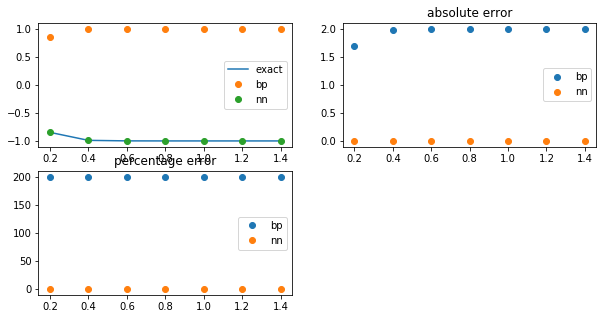

In [192]:
%matplotlib inline
label="M"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn], init_=1)
plt.show()

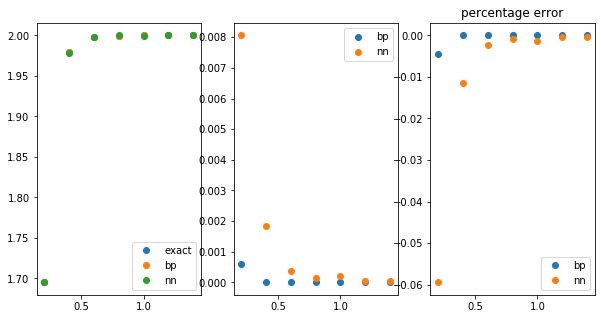

In [193]:
%matplotlib inline
label="M_i"
import imp
imp.reload(solvers)

plt= solvers.plot_quantity_sum(label, res_ex, [res_bp, res_nn], init_=1)
plt.show()

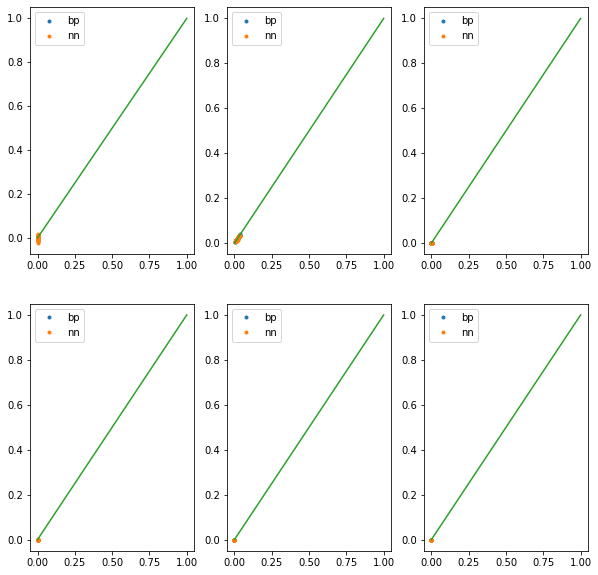

In [194]:
import solvers
imp.reload(solvers)
plt = solvers.plot_all_corr(betas_fast[0:6], res_ex, [res_bp, res_nn], J_interaction)
plt.show()

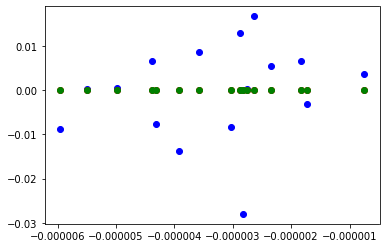

In [195]:
import matplotlib.pyplot as plt
plt.plot(res_ex["M_i"][0], res_nn["M_i"][0], "bo")
plt.plot(res_ex["M_i"][0], res_bp["M_i"][0], "ro")
plt.plot(res_ex["M_i"][0], np.tanh(1e-6*H), "go")
